# Whole brain data processing

### Making mask

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing import *
import zarr
import scipy.ndimage.filters as sfilter
from utils import intesity_mask
from fish_proc.utils.snr import local_correlations_fft

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def force_bkill_dask():
    try:
        get_ipython().run_cell_magic('bash', '', 'bkill -q normal 0\n')
    except:
        get_ipython().run_cell_magic('bash', '', 'bjobs\n')

## Set up environments

* Install `fish_proc` from github https://github.com/zqwei/fish_processing

In [3]:
## STEP 1: specify data and save path
dir_root = '/groups/ahrens/ahrenslab/jing/giving_up/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013/im'
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013'
if not os.path.exists(save_root):
    os.makedirs(save_root)

In [4]:
nsplit = 8
baseline_percentile = 20  
baseline_window = 400   # number of frames

## Mask
Making a mask for data to decrease the number of computation in demix
* remove low intensity pixel
* remove low snr pixel
* remove low local pixel correlation pixels

This will generate the follow files at `save_root` folder
* `mask_map.h5` -- mask
* `local_correlation_map.h5` -- local correlation
* `masked_local_pca_data.zarr` -- df/f computation
* `masked_downsampled_local_pca_data.zarr` -- downsampled in time -> used for cell segmentation, which can be removed afterwards

### Note
* ZW -- intensity_percentile can be experimented using notebook `Test_for_pipeline_mask`
* ZW -- I used 50% for examplary data

In [5]:
# Y_d_ave_ = zarr.open(f'{save_root}/Y_ave.zarr', 'r')
Y_d_ave_ = zarr.open(f'{save_root}/Y_max.zarr', 'r')
intensity_percentile = np.ones(Y_d_ave_.shape[0])*50
intensity_percentile[17] = 70
intensity_percentile[18] = 80
intensity_percentile[19] = 90
intensity_percentile[20] = 95
mask = np.zeros(Y_d_ave_.shape).astype('bool')
for n, n_ave_ in enumerate(Y_d_ave_):
    mask_ = intesity_mask(n_ave_, intensity_percentile[n])
    mask_median = sfilter.median_filter(mask_.squeeze().astype('int'), size=7) == 1
    mask[n] = mask_ & mask_median[:, :, None]

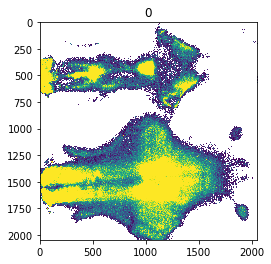

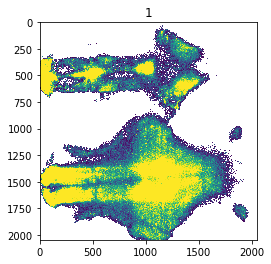

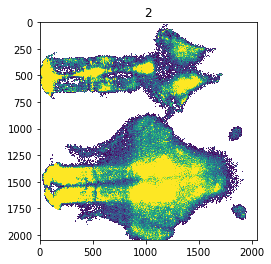

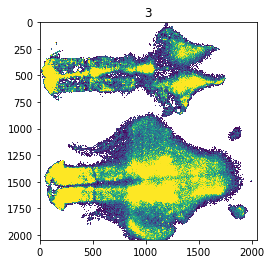

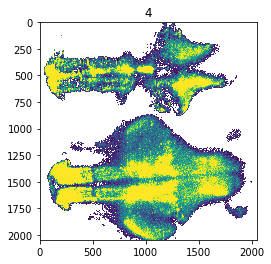

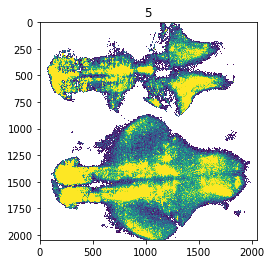

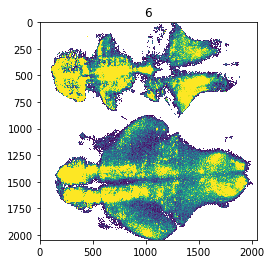

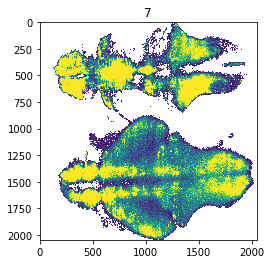

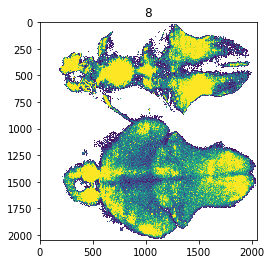

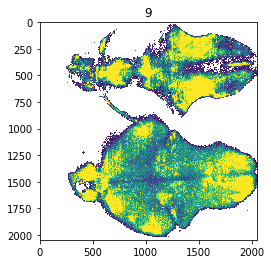

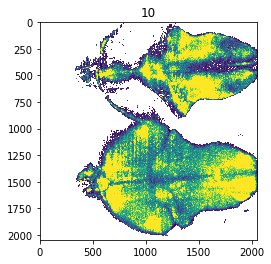

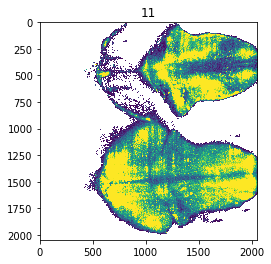

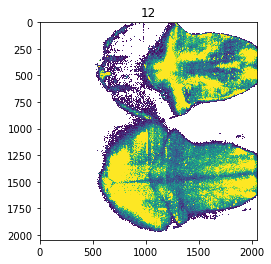

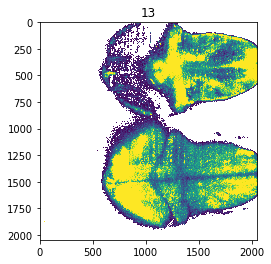

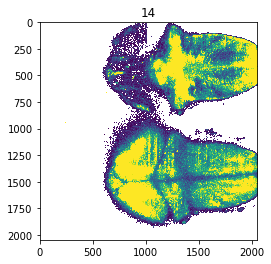

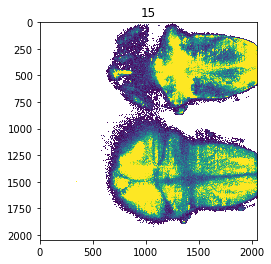

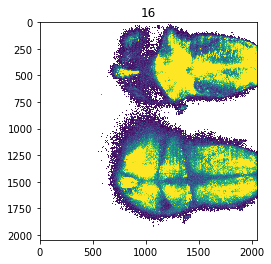

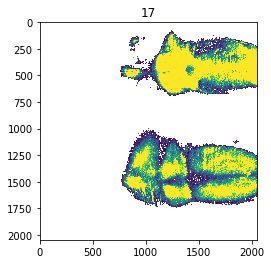

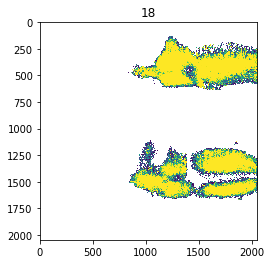

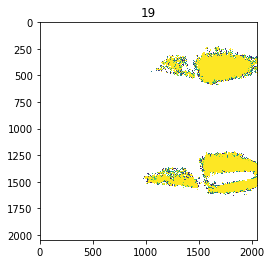

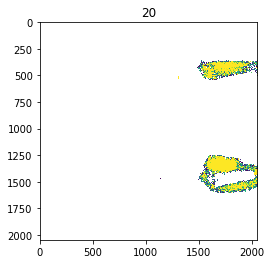

In [6]:
for n, n_ave_ in enumerate(Y_d_ave_):
    int_ = intensity_percentile[n]
    _ = n_ave_.copy()
    _[~mask[n]] = np.nan
    plt.imshow(_.squeeze(), vmax=np.percentile(n_ave_, max(int_+3, 90)), vmin=np.percentile(n_ave_, int_))
    # plt.imshow(mask[n].squeeze(), cmap='gray', alpha=0.7)
    plt.title(n)
    plt.show()

In [7]:
z, x, y, _ = mask.shape
cluster, client = fdask.setup_workers(1)
mask = da.from_array(mask, chunks=(1, x//nsplit, y//nsplit, -1))

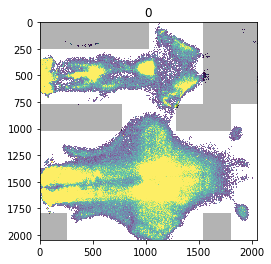

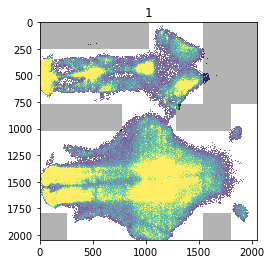

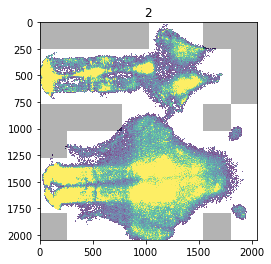

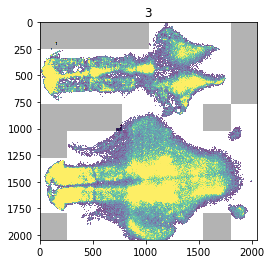

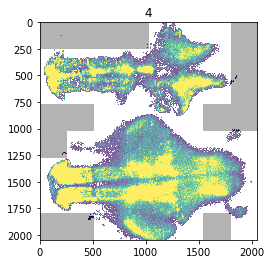

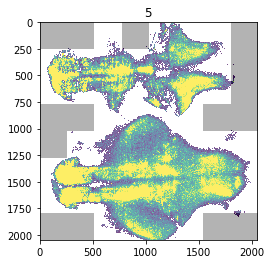

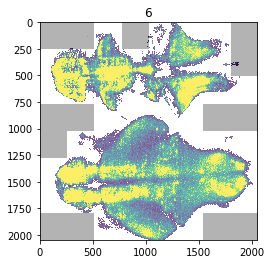

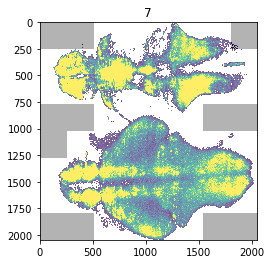

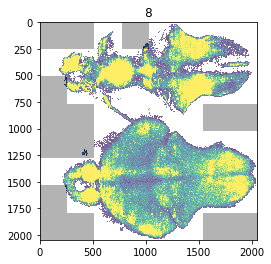

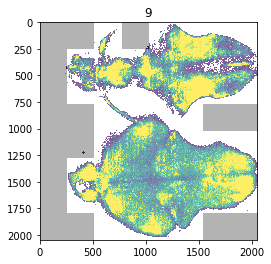

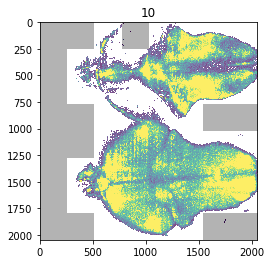

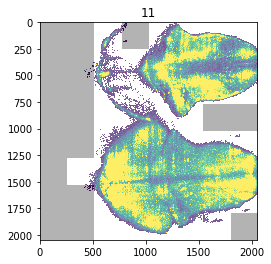

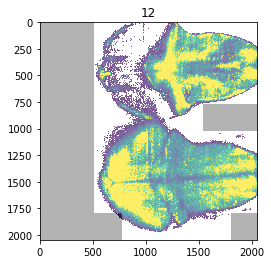

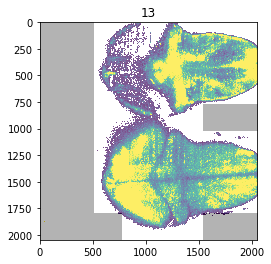

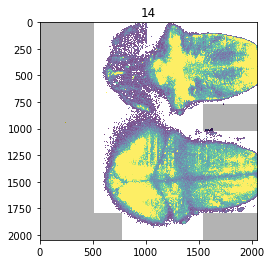

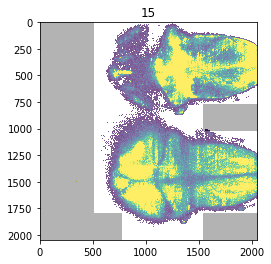

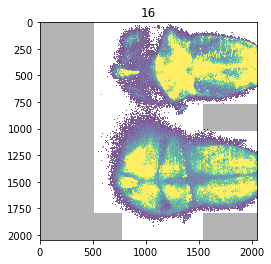

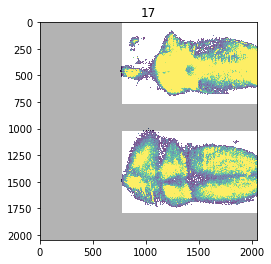

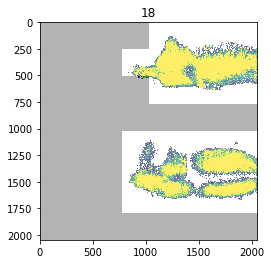

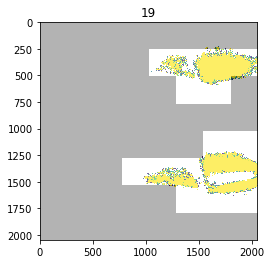

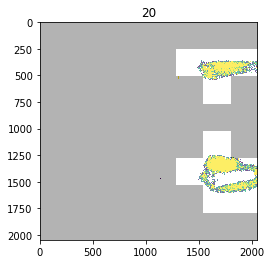

In [8]:
mask_sum = mask.map_blocks(lambda v:v.sum()*np.ones((1, x//nsplit, y//nsplit, 1))).compute()>2500
for n, n_ave_ in enumerate(Y_d_ave_):
    int_ = intensity_percentile[n]
    _ = n_ave_.copy()
    _[~mask[n]] = np.nan
    plt.imshow(_.squeeze(), vmax=np.percentile(n_ave_, max(int_+3, 90)), vmin=np.percentile(n_ave_, int_))
    plt.imshow(mask_sum[n].squeeze(), cmap='gray', alpha=0.3)
    plt.title(n)
    plt.show()

### Overwrite the previous mask if the current one is going to be used

In [ ]:
da.from_array((mask.compute() & mask_sum), chunks=(1, x//nsplit, y//nsplit, -1)).to_zarr(f'{save_root}/mask_map.zarr', overwrite=True)

### Check again the mask before other processing

In [9]:
mask = da.from_zarr(f'{save_root}/mask_map.zarr')

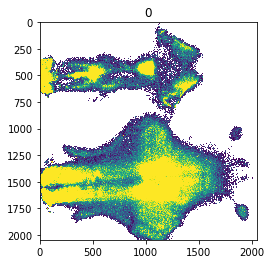

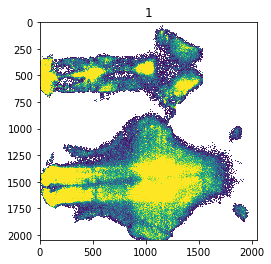

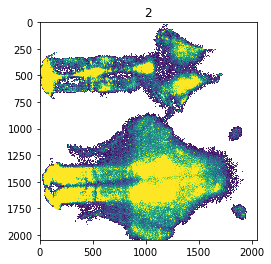

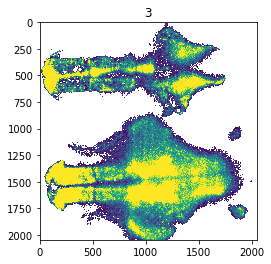

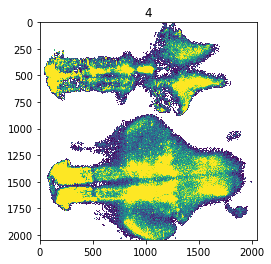

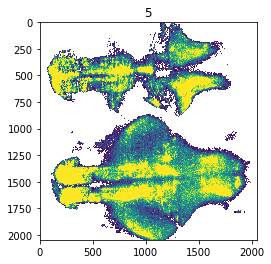

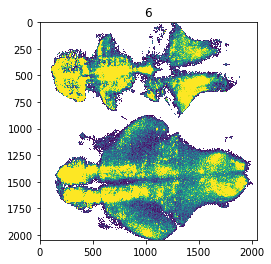

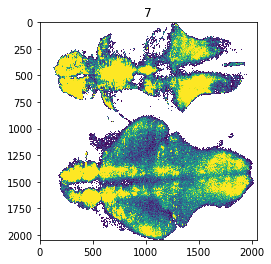

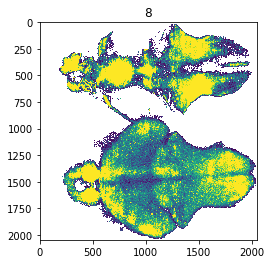

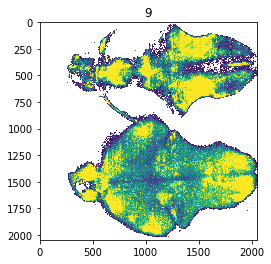

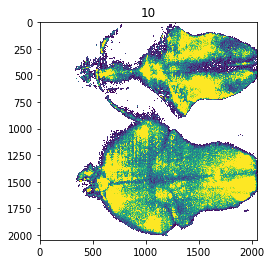

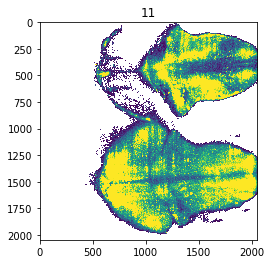

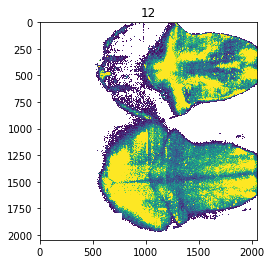

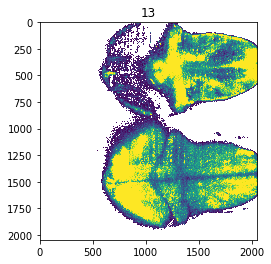

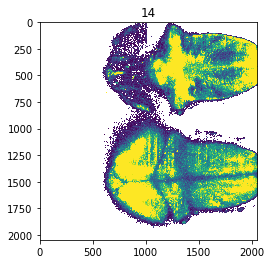

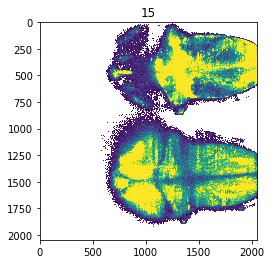

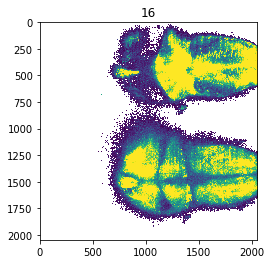

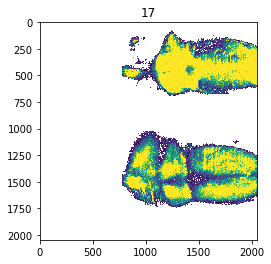

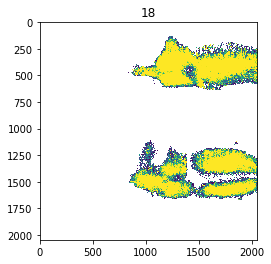

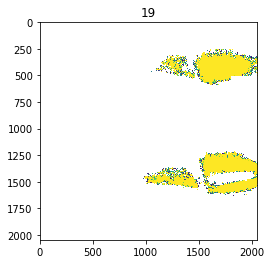

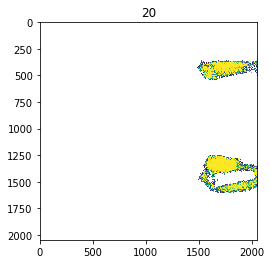

In [10]:
for n, n_ave_ in enumerate(Y_d_ave_):
    int_ = intensity_percentile[n]
    _ = n_ave_.copy()
    _[~mask[n]] = np.nan
    plt.imshow(_.squeeze(), vmax=np.percentile(n_ave_, max(int_+3, 90)), vmin=np.percentile(n_ave_, int_))
    plt.title(n)
    plt.show()